In [1]:
'''
To compute CD signatures for LINCS L1000 level3 data using 
all profiles in the same batch as controls
and add results to mongodb.
''' 
import os, sys, json
import h5py
from pymongo import MongoClient
import geode

sys.path.append('/Users/zichen/Documents/bitbucket/maayanlab_utils')
from parallel import *
from fileIO import file2list


sys.path.append('/Users/zichen/Documents/GitHub/l1ktools/python')
import cmap.io.gct as gct


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'

import seaborn as sns
sns.set_context('talk', font_scale=1.5)


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# 0. Load LINCS L1000 level 3 data from gctx file and made function to subset this matrix by probe_ids and sample_ids

In [3]:
GCTX_FILE = '/Users/zichen/Documents/Zichen_Projects/L1000_DR/data/q2norm_n1328098x22268.gctx'
PROBES = json.load(open('/Users/zichen/Documents/bitbucket/lincs_l1000_limma/rid.json', 'rb'))
PROBES_LM1000 = file2list('/Users/zichen/Documents/bitbucket/lincs_l1000_limma/rid_lm1000.txt', 0)

print len(PROBES), len(PROBES_LM1000)
print PROBES[:5]
print PROBES_LM1000[:5]

22268 978
[u'200814_at', u'222103_at', u'201453_x_at', u'204131_s_at', u'200059_s_at']
['200814_at', '222103_at', '201453_x_at', '204131_s_at', '200059_s_at']


In [4]:
gctx = h5py.File(GCTX_FILE, 'r')
mat = gctx['/0/DATA/0/matrix']
print mat.shape

gene_ids = list(gctx['/0/META/ROW/id'])
print len(gene_ids), gene_ids[:5]

(1328098, 22268)
22268 ['200814_at', '222103_at', '201453_x_at', '204131_s_at', '200059_s_at']


In [5]:
gctx['/0/META/COL/id'][:5]

array(['CPC005_A375_6H_X1_B3_DUO52HI53LO:K06',
       'CPC005_A375_6H_X2_B3_DUO52HI53LO:K06',
       'CPC005_A375_6H_X3_B3_DUO52HI53LO:K06',
       'CPC005_A375_6H_X1_B3_DUO52HI53LO:C19',
       'CPC005_A375_6H_X2_B3_DUO52HI53LO:C19'], 
      dtype='|S46')

In [6]:
print np.in1d(PROBES, PROBES_LM1000).sum()
print np.in1d(PROBES, PROBES_LM1000)[:978].sum()

978
978


In [7]:
def slice_matrix(gctx, cids, rids):
    '''Slice the mat by cids and rids and ensure the mat 
    is ordered by cids and rids.'''    
    all_cids = gctx['/0/META/COL/id']
    c_mask = np.in1d(all_cids, cids)
    cids_subset = all_cids[c_mask].tolist()
    c_indices = np.array([cids_subset.index(id_) 
                          for id_ in cids])

    mat = gctx['/0/DATA/0/matrix']
    submat = mat[c_mask, :][c_indices, :]
    
    all_rids = gctx['/0/META/ROW/id']
    r_mask = np.in1d(all_rids, rids)
    rids_subset = all_rids[r_mask].tolist()
    r_indices = np.array([rids_subset.index(id_) 
                          for id_ in rids])
    submat = submat[:, r_mask][:, r_indices]

    return submat

# 1. Connect to MongoDB to retrieve all `sig_id`s that are `trt_cp`

In [8]:
client = MongoClient("mongodb://146.203.54.131:27017")
DB = client['LINCS_L1000_limma']
COLL_SIG = DB['siginfo'] # to get metadata

In [9]:
# Collect pert_ids and batches
cur = COLL_SIG.find({'pert_type':'trt_cp'}, 
                    {'_id':False, 'sig_id':True, 'distil_id':True})
print cur.count()


206339


In [10]:
# Load the metadata for the currently visualized L1000 signatures in L1000FWD
sig_meta_df = pd.read_csv('../data/metadata-full.tsv', sep='\t').set_index('sig_id')
print sig_meta_df.shape
sig_meta_df.head()

(89419, 6)


,cell,dose,pert_id,perturbation,pvalue,time
sig_id,,,,,,
CPC015_MCF7_6H:BRD-A00546892:10.0,MCF7,10.0,BRD-A00546892,-666,0.0143,6
CPC004_VCAP_6H:BRD-A00546892:10.0,VCAP,10.0,BRD-A00546892,BIPERIDEN,0.2056,6
CPC015_ASC_24H:BRD-A00546892:10.0,ASC,10.0,BRD-A00546892,-666,0.2475,24
CPC004_VCAP_24H:BRD-A00546892:10.0,VCAP,10.0,BRD-A00546892,BIPERIDEN,0.3039,24
CPC015_PHH_24H:BRD-A00546892:10.0,PHH,10.0,BRD-A00546892,-666,0.3584,24


In [11]:
print sig_meta_df['pert_id'].nunique()
pert_id_include = set(sig_meta_df['pert_id'].unique())


5312


In [12]:
# Retrieve sig_meta from the MongoDB
cur = COLL_SIG.find({'pert_type':'trt_cp'},
                    {'_id':False, 
                     'sig_id':True, 
                     'distil_id':True,
                    })
sig_meta_df_full = pd.DataFrame([doc for doc in cur]).set_index('sig_id')
print sig_meta_df_full.shape

cur = COLL_SIG.find({'$and': [ 
                        {'pert_type':'trt_cp'},
                        {'distil_nsample': {'$gt': 1}}
                    ]}, 
                    {'_id':False, 
                     'sig_id':True, 
                     'distil_id':True,
                     'pert_id': True,
                     'pert_dose':True,
                     'pert_time':True,
                     'cell_id':True,
                     'pert_desc':True,
                    })
print cur.count()

sig_meta_df = pd.DataFrame([doc for doc in cur if doc['pert_id'] in pert_id_include]).set_index('sig_id')
print sig_meta_df.shape
sig_meta_df.head()

(206339, 1)
202666
(128017, 6)


,cell_id,distil_id,pert_desc,pert_dose,pert_id,pert_time
sig_id,,,,,,
CVD001_HUH7_24H:BRD-K07762753-001-03-6:50,HUH7,"[CVD001_HUH7_24H_X1_F1B3_DUO52HI53LO:M03, CVD0...",-666,50.0,BRD-K07762753,24.0
CPC004_PC3_6H:BRD-K34820100-001-02-1:10,PC3,"[CPC004_PC3_6H_X1_B3_DUO52HI53LO:N23, CPC004_P...",TEBUTHIURON,10.0,BRD-K34820100,6.0
CPC004_PC3_6H:BRD-A22844106-001-16-1:10,PC3,"[CPC004_PC3_6H_X1_B3_DUO52HI53LO:I08, CPC004_P...",TENOXICAM,10.0,BRD-A22844106,6.0
CPC004_PC3_6H:BRD-A55393291-001-05-7:10,PC3,"[CPC004_PC3_6H_X1_B3_DUO52HI53LO:D03, CPC004_P...",TESTOSTERONE,10.0,BRD-A55393291,6.0
CPC004_PC3_6H:BRD-A93255169-001-13-5:10,PC3,"[CPC004_PC3_6H_X1_B3_DUO52HI53LO:F12, CPC004_P...",THALIDOMIDE,10.0,BRD-A93255169,6.0


In [53]:
sig_meta_df.query('pert_id == "BRD-K34820100"')

,cell_id,distil_id,pert_desc,pert_dose,pert_id,pert_time,batch
sig_id,,,,,,,
CPC004_PC3_6H:BRD-K34820100-001-02-1:10,PC3,"[CPC004_PC3_6H_X1_B3_DUO52HI53LO:N23, CPC004_P...",TEBUTHIURON,10.0,BRD-K34820100,6.0,CPC004_PC3_6H
CPC004_A375_6H:BRD-K34820100-001-02-1:10,A375,"[CPC004_A375_6H_X1_B3_DUO52HI53LO:N23, CPC004_...",TEBUTHIURON,10.0,BRD-K34820100,6.0,CPC004_A375_6H
CPC004_HA1E_6H:BRD-K34820100-001-02-1:10,HA1E,"[CPC004_HA1E_6H_X1_B3_DUO52HI53LO:N23, CPC004_...",TEBUTHIURON,10.0,BRD-K34820100,6.0,CPC004_HA1E_6H
CPC004_HA1E_24H:BRD-K34820100-001-02-1:10,HA1E,"[CPC004_HA1E_24H_X1_B3_DUO52HI53LO:N23, CPC004...",TEBUTHIURON,10.0,BRD-K34820100,24.0,CPC004_HA1E_24H
CPC004_HCC515_6H:BRD-K34820100-001-02-1:10,HCC515,"[CPC004_HCC515_6H_X1_B3_DUO52HI53LO:N23, CPC00...",TEBUTHIURON,10.0,BRD-K34820100,6.0,CPC004_HCC515_6H
CPC004_HCC515_24H:BRD-K34820100-001-02-1:10,HCC515,"[CPC004_HCC515_24H_X1_B3_DUO52HI53LO:N23, CPC0...",TEBUTHIURON,10.0,BRD-K34820100,24.0,CPC004_HCC515_24H
CPC004_HEPG2_6H:BRD-K34820100-001-02-1:10,HEPG2,"[CPC004_HEPG2_6H_X1_B5_DUO52HI53LO:N23, CPC004...",TEBUTHIURON,10.0,BRD-K34820100,6.0,CPC004_HEPG2_6H
CPC004_HT29_6H:BRD-K34820100-001-02-1:10,HT29,"[CPC004_HT29_6H_X1_B3_DUO52HI53LO:N23, CPC004_...",TEBUTHIURON,10.0,BRD-K34820100,6.0,CPC004_HT29_6H
CPC004_MCF7_6H:BRD-K34820100-001-02-1:10,MCF7,"[CPC004_MCF7_6H_X1_B3_DUO52HI53LO:N23, CPC004_...",TEBUTHIURON,10.0,BRD-K34820100,6.0,CPC004_MCF7_6H


In [13]:
# Get batch info
sig_meta_df_full['batch'] = sig_meta_df_full.index.map(lambda x:x.split(':')[0])
print sig_meta_df_full['batch'].nunique()

sig_meta_df['batch'] = sig_meta_df.index.map(lambda x:x.split(':')[0])
print sig_meta_df['batch'].nunique()

654
651


# 2. Apply normalization for each batch, then compute signatures and insert in to MongoDB

The normalization method is described in [Iskar et al PLoS comp Bio, 2010]():

```
for batch in batches:
    1. discard control samples
    2. mean center each probe across treatment samples in batch
    3. average replicate treatment samples as the signature
```

## 2.1. First examine the effect of mean centering for samples on batch and on plates

In [14]:
import RNAseq

/usr/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [106]:
# Look at a particular signature
# sig_id = 'CPC004_A375_6H:BRD-K34820100-001-02-1:10'
sig_id = 'CPC004_MCF7_6H:BRD-K34820100-001-02-1:10'
distil_ids = sig_meta_df.ix[sig_id]['distil_id']
batch = sig_meta_df.ix[sig_id]['batch']
print distil_ids
print batch

[u'CPC004_MCF7_6H_X1_B3_DUO52HI53LO:N23', u'CPC004_MCF7_6H_X2_B3_DUO52HI53LO:N23', u'CPC004_MCF7_6H_X4_F1B5_DUO52HI53LO:N23']
CPC004_MCF7_6H


In [107]:
# Get all the treatment samples in this batch
distil_ids_sub = reduce(lambda x, y: x + y, 
                        sig_meta_df_full.query('batch == "%s"' % batch)['distil_id'])
distil_ids_sub = sorted(distil_ids_sub)
print len(distil_ids_sub)
plate_ids_sub = map(lambda x:x.split(':')[0], distil_ids_sub)
print len(set(plate_ids_sub))

1414
4


In [108]:
# Retrieve the expression matrix on this batch
mat_sub = slice_matrix(gctx, distil_ids_sub, PROBES_LM1000)
print mat_sub.shape

(1414, 978)


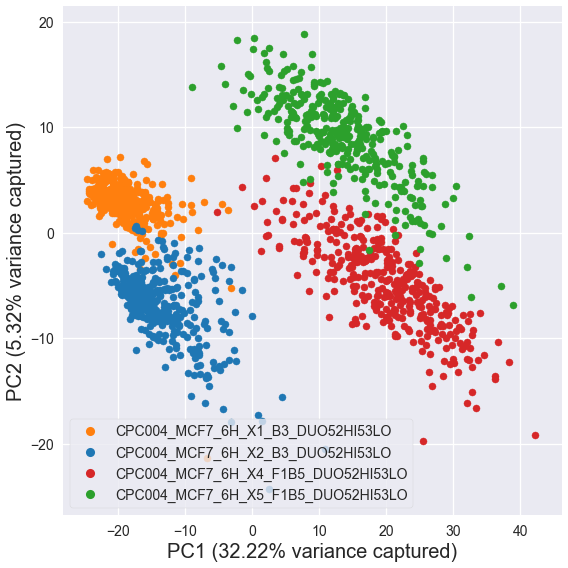

In [109]:
RNAseq.PCA_plot(mat_sub.T, samples=distil_ids_sub, standardize=2, log=False,  sep=':')

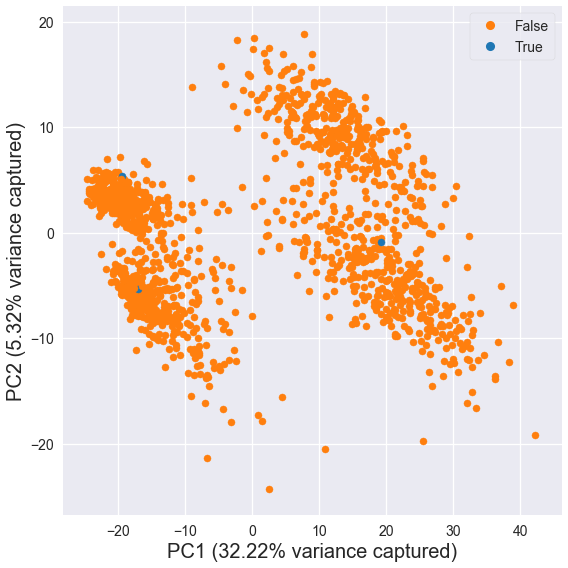

In [110]:
# Highlight the 5 treatment samples of interest
RNAseq.PCA_plot(mat_sub.T, samples=np.in1d(distil_ids_sub, distil_ids).astype(str), standardize=2, log=False,  sep=' ')

In [111]:
# Mean center the probes
mat_sub_centered = mat_sub - mat_sub.mean(axis=0)
print mat_sub_centered.shape

(1414, 978)


In [112]:
# Look at another signature of the same drug, same cell on a different batch
# sig_id2 = 'CPC015_A375_6H:BRD-K34820100-001-02-1:10'
sig_id2 = 'CPC015_MCF7_6H:BRD-K34820100-001-02-1:10'
distil_ids2 = sig_meta_df.ix[sig_id2]['distil_id']
batch2 = sig_meta_df.ix[sig_id2]['batch']
print distil_ids2
print batch2

[u'CPC015_MCF7_6H_X1_B4_DUO52HI53LO:B13', u'CPC015_MCF7_6H_X2_B4_DUO52HI53LO:B13', u'CPC015_MCF7_6H_X3_B3_DUO52HI53LO:B13', u'CPC015_MCF7_6H_X3_B4_DUO52HI53LO:B13', u'CPC015_MCF7_6H_X4_F2B4_DUO52HI53LO:B13', u'CPC015_MCF7_6H_X5_F1B5_DUO52HI53LO:B13']
CPC015_MCF7_6H


In [113]:
# Get all the treatment samples in this batch
distil_ids_sub2 = reduce(lambda x, y: x + y, 
                        sig_meta_df_full.query('batch == "%s"' % batch2)['distil_id'])
distil_ids_sub2 = sorted(distil_ids_sub2)
print len(distil_ids_sub2)
plate_ids_sub2 = map(lambda x:x.split(':')[0], distil_ids_sub2)
print len(set(plate_ids_sub2))

2171
6


In [114]:
# Retrieve the expression matrix on this batch
mat_sub2 = slice_matrix(gctx, distil_ids_sub2, PROBES_LM1000)
print mat_sub2.shape

(2171, 978)


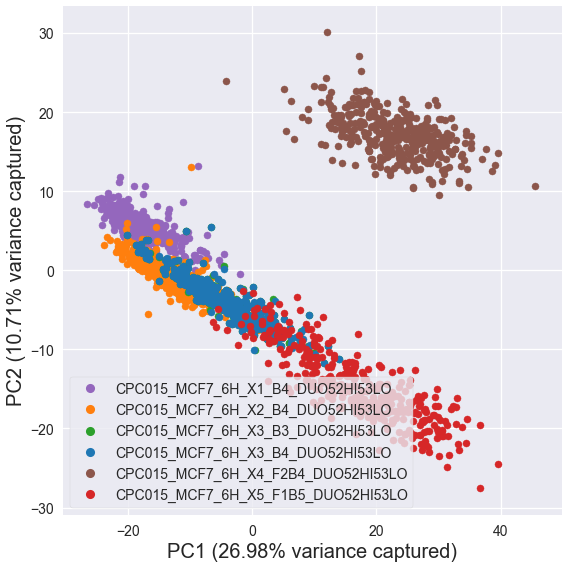

In [115]:
RNAseq.PCA_plot(mat_sub2.T, samples=distil_ids_sub2, standardize=2, log=False,  sep=':')

(3585, 978)
3585


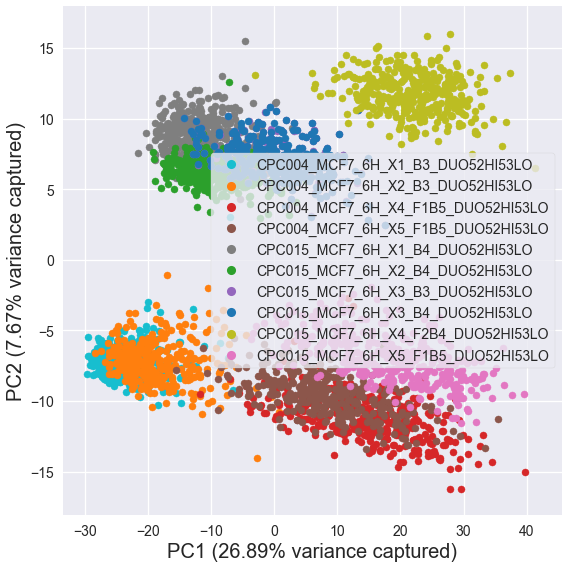

In [116]:
# Concat those two batches
mat_sub_sub2 = np.vstack((mat_sub, mat_sub2))
print mat_sub_sub2.shape
print len(distil_ids_sub + distil_ids_sub2)
RNAseq.PCA_plot(mat_sub_sub2.T, 
                samples=distil_ids_sub + distil_ids_sub2, 
                standardize=2, log=False,  sep=':')

3585


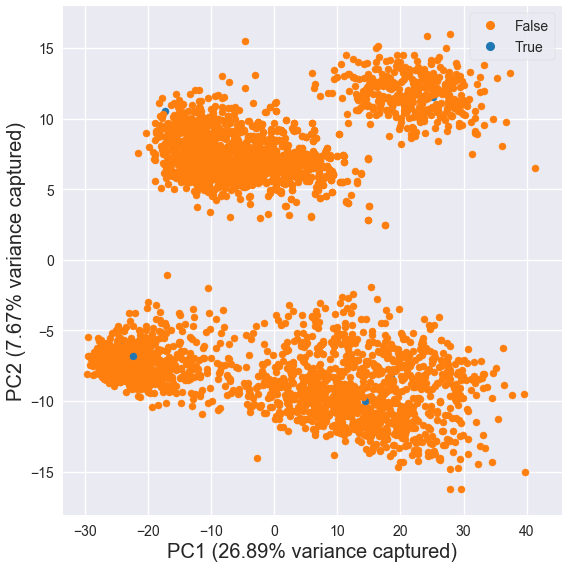

In [117]:
# Concat those two batches
print len(distil_ids_sub + distil_ids_sub2)
RNAseq.PCA_plot(mat_sub_sub2.T, 
                samples=np.in1d(distil_ids_sub + distil_ids_sub2, distil_ids+distil_ids2).astype(str), 
                standardize=2, log=False,  sep=':')

(3585, 978)
3585


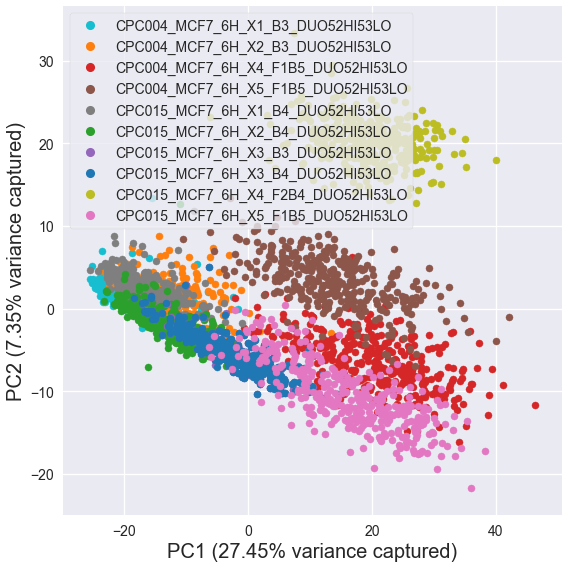

In [118]:
# Concat those two mean-centered batches
mat_sub2_centered = mat_sub2 - mat_sub2.mean(axis=0)
mat_sub_sub2_centered = np.vstack((mat_sub_centered, mat_sub2_centered))
print mat_sub_sub2.shape
print len(distil_ids_sub + distil_ids_sub2)
RNAseq.PCA_plot(mat_sub_sub2_centered.T, 
                samples=distil_ids_sub + distil_ids_sub2, 
                standardize=2, log=False,  sep=':')

(3585, 978)
3585


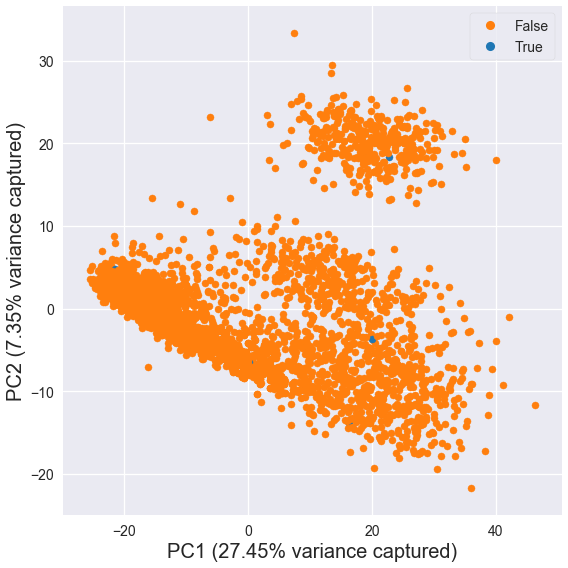

In [119]:
# Concat those two mean-centered batches
mat_sub2_centered = mat_sub2 - mat_sub2.mean(axis=0)
mat_sub_sub2_centered = np.vstack((mat_sub_centered, mat_sub2_centered))
print mat_sub_sub2.shape
print len(distil_ids_sub + distil_ids_sub2)
RNAseq.PCA_plot(mat_sub_sub2_centered.T, 
                samples=np.in1d(distil_ids_sub + distil_ids_sub2, distil_ids+distil_ids2).astype(str), 
                standardize=2, log=False,  sep=':')

In [120]:
# Do mean-centering on each plates
plates = map(lambda x:x.split(':')[0], distil_ids_sub + distil_ids_sub2)
print len(set(plates))
mat_sub_sub2_plate_mean_centered = np.zeros_like(mat_sub_sub2)
for plate in set(plates):
    plate_mask = np.in1d(plates, [plate])
    mat_sub_plate = mat_sub_sub2[plate_mask]
    print mat_sub_plate.shape
    mat_sub_sub2_plate_mean_centered[plate_mask, :] = mat_sub_plate - mat_sub_plate.mean(axis=0)


10
(361, 978)
(356, 978)
(362, 978)
(358, 978)
(361, 978)
(343, 978)
(363, 978)
(360, 978)
(364, 978)
(357, 978)


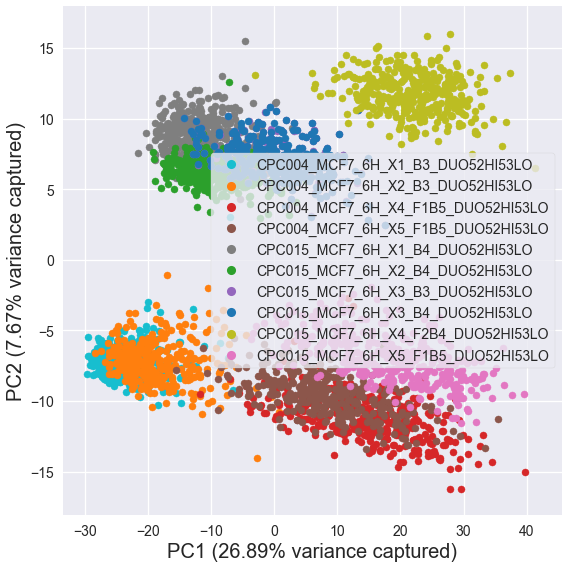

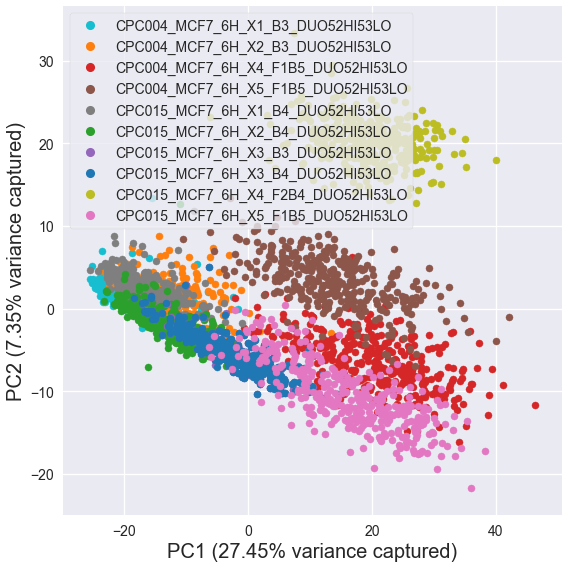

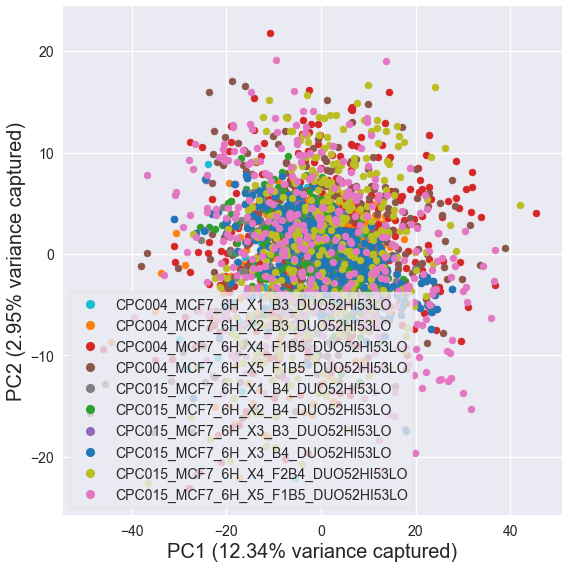

In [121]:
RNAseq.PCA_plot(mat_sub_sub2.T, 
                samples=distil_ids_sub + distil_ids_sub2, 
                standardize=2, log=False,  sep=':')

RNAseq.PCA_plot(mat_sub_sub2_centered.T, 
                samples=distil_ids_sub + distil_ids_sub2, 
                standardize=2, log=False,  sep=':')

RNAseq.PCA_plot(mat_sub_sub2_plate_mean_centered.T, 
                samples=distil_ids_sub + distil_ids_sub2, 
                standardize=2, log=False,  sep=':')

## There are two levels of batch effects:
1. plates (biological replicates): CPC004_A375_6H_X1 vs CPC004_A375_6H_X2
2. batch: CPC004_A375_6H vs CPC015_A375_6H

---

In [14]:
# Make MongoDB to store those data
client_local = MongoClient('mongodb://127.0.0.1:27017')
db = client_local['L1000FWD']
coll = db['sigs']
coll.create_index('sig_id', unique=True)

u'sig_id_1'

In [15]:
from joblib import delayed, Parallel

In [16]:
def compute_signatures(sig_id, row, distil_ids_sub, mat, mat_centered, PROBES_LM1000):
    distil_ids_pert = row['distil_id']
    # Make the sample_class
    mask_pert = np.in1d(distil_ids_sub, distil_ids_pert)
    sample_class = mask_pert.astype(int) + 1
    sample_class = list(sample_class)

    # Apply CD on the original mat
    cd1 = geode.chdir(mat.T, sample_class, PROBES_LM1000, 
                      calculate_sig=0, sort=False, gamma=0.5)

    # Apply CD on the mean centered mat
    cd2 = geode.chdir(mat_centered.T, sample_class, PROBES_LM1000, 
                      calculate_sig=0, sort=False, gamma=0.5)
    # Averaging profiles after mean centering
    avg_vals = mat_centered[mask_pert].mean(axis=0)

    doc = row.to_dict()
    doc['sig_id'] = sig_id
    doc['CD_nocenter_LM'] = list(np.array([item[0] for item in cd1], dtype=np.float64))
    doc['CD_center_LM'] = list(np.array([item[0] for item in cd2], dtype=np.float64))
    doc['avg_center_LM'] = list(avg_vals.astype(np.float64))

    return doc

In [21]:
# Get all inserted document sig_ids
inserted_sig_ids = set(coll.distinct('sig_id'))
print 'Number of sig_ids inserted: %d' % len(inserted_sig_ids)

sig_ids_left = list(set(sig_meta_df.index) - inserted_sig_ids)

# subset the sig_meta_df
sig_meta_df_left = sig_meta_df.ix[sig_ids_left]
all_batches = sig_meta_df_left['batch'].unique()
n_batches = len(all_batches)
print sig_meta_df_left.shape

for c, batch in enumerate(all_batches):
    sig_meta_df_sub = sig_meta_df_left.query('batch == "%s"' % batch)
    
    # all the treatment samples in this batch
    distil_ids_sub = reduce(lambda x, y: x + y, 
                            sig_meta_df_full.query('batch == "%s"' % batch)['distil_id'])
    print c, n_batches
    print '\t', batch, sig_meta_df_sub.shape, len(distil_ids_sub)
    # Slice the matrix
    mat = slice_matrix(gctx, distil_ids_sub, PROBES_LM1000)
    print '\t', mat.shape
    # Mean center the probes
    mat_centered = mat - mat.mean(axis=0)
    try:
        docs = Parallel(n_jobs=7, backend='multiprocessing', verbose=10)(\
                                  delayed(compute_signatures)(sig_id, row, distil_ids_sub, mat, mat_centered, PROBES_LM1000)\
                                  for sig_id, row in sig_meta_df_sub.iterrows())
    except:
        pass
    else:                     
        result = coll.insert_many(docs)


    


Number of sig_ids inserted: 127963
(54, 7)
0 1
	NMH001_NEU_24H (54, 7) 1023
	(1023, 978)


In [23]:
print sig_meta_df.shape
sig_meta_df.to_csv('data/sig_metadata_%d.csv' % sig_meta_df.shape[0])

(128017, 7)
